# Description

- Initialize with returns, predictions, target volatility, and oos start date
- Evaluate portfolios generated from the predictions

# Imports

In [5]:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd

import core.artificial_signal_generators as sig_gen
import core.config as cconfig
import core.dataflow_model.model_evaluator as modeval
import core.dataflow_model.model_plotter as modplot
import core.dataflow_model.utils as cdmu
import core.statistics as stats
import helpers.dbg as dbg
import helpers.printing as prnt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

# _LOG.info("%s", env.get_system_signature()[0])

prnt.config_notebook()

# Notebook config

In [7]:
# Dir containing the experiment results in the format generated by
# `save_experiment_result_bundle`.
#exp_dir = "/app/experiment1"
exp_dir = "/cache/experiments/experiment.RH1E.top100.15T.gp.20210721-17_08_46"
dbg.dassert_dir_exists(exp_dir) 
    
eval_config = cconfig.get_config_from_nested_dict(
    {
        "exp_dir": exp_dir,
        "model_evaluator_kwargs": {
            "returns_col": "ret_0_vol_adj_2",
            "predictions_col": "ret_0_vol_adj_2_hat",
            "oos_start": "2017-01-01",
        },
        "bh_adj_threshold": 0.1,
        "resample_rule": "W",
        "mode": "ins",
        "target_volatility": 0.1,
    }
)

# Generate mock returns and predictions

- This is a placeholder
- In practice, the user should supply `rets` and `preds`

In [8]:
# Generate synthetic returns.
mn_process = sig_gen.MultivariateNormalProcess()
mn_process.set_cov_from_inv_wishart_draw(dim=32, seed=0)
realization = mn_process.generate_sample(
    {"start": "2000-01-01", "end": "2010-01-01", "freq": "B"}, seed=0
)
rets = realization.to_dict(orient="series")

In [9]:
# Generate fake predictions.
noise = sig_gen.MultivariateNormalProcess(
    pd.Series(data=[0] * 32), pd.DataFrame(np.identity(32))
)
noise_draw = noise.generate_sample(
    {"start": "2000-01-01", "end": "2010-01-01", "freq": "B"}, seed=0
)
pred_df = 0.01 * realization + 0.1 * noise_draw
# Adjust so that all models have positive SR.
pred_df = (
    stats.compute_annualized_sharpe_ratio(pred_df.multiply(realization))
    .apply(np.sign)
    .multiply(pred_df)
)

# Initialize ModelEvaluator and ModelPlotter

In [10]:
if eval_config.get("exp_dir", None) is None:
    evaluator = modeval.ModelEvaluator(
        data=data_dict,
        target_col="returns",
        prediction_col="predictions",
        oos_start=eval_config["model_evaluator_kwargs", "oos_start"],
    )
else:
    result_bundles = cdmu.yield_experiment_artifacts(
        eval_config["exp_dir"], "result_bundle.pkl",
    )
    evaluator = modeval.build_model_evaluator_from_result_bundles(
        result_bundles,
        **eval_config["model_evaluator_kwargs"].to_dict(),
    )

plotter = modplot.ModelPlotter(evaluator)

# Load artifacts 'result_bundle.pkl' from '/cache/experiments/experiment.RH1E.top100.15T.gp.20210721-17_08_46'
Found 100 experiment subdirs in '/cache/experiments/experiment.RH1E.top100.15T.gp.20210721-17_08_46'


Loading artifacts:   0%|          | 0/100 [00:00<?, ?it/s]

Can't find '{file_name_tmp}': skipping
Can't find '{file_name_tmp}': skipping
Can't find '{file_name_tmp}': skipping
Can't find '{file_name_tmp}': skipping
Can't find '{file_name_tmp}': skipping
Can't find '{file_name_tmp}': skipping
Can't find '{file_name_tmp}': skipping


Calculating positions:   0%|          | 0/93 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/93 [00:00<?, ?it/s]

Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`
Empty input series `pnl`


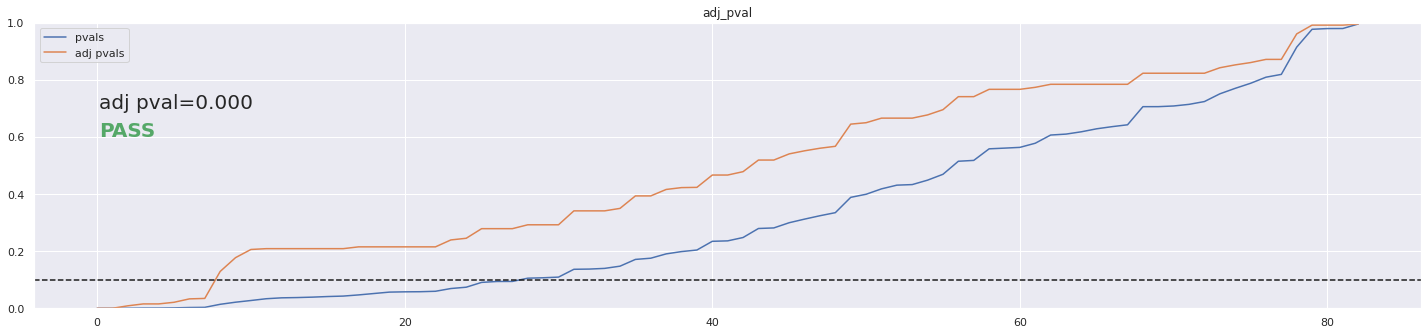

In [11]:
plotter.plot_multiple_tests_adjustment(
    threshold=eval_config["bh_adj_threshold"], mode=eval_config["mode"]
)

In [12]:
pnl_stats = evaluator.calculate_stats(
    mode=eval_config["mode"], target_volatility=eval_config["target_volatility"]
)
pnl_stats.loc[["signal_quality", "correlation"]]

Calculating positions:   0%|          | 0/93 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/93 [00:00<?, ?it/s]

Calculating stats:   0%|          | 0/93 [00:00<?, ?it/s]

ValueError: Need at least 3 dates to infer frequency

In [ ]:
plotter.plot_correlation_matrix(
    series="pnl",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

In [ ]:
plotter.plot_correlation_matrix(
    series="returns",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

In [ ]:
col_mask = (
    pnl_stats.loc["signal_quality"].loc["sr.adj_pval"]
    < eval_config["bh_adj_threshold"]
)
selected = pnl_stats.loc[:, col_mask].columns.to_list()

In [ ]:
plotter.plot_multiple_pnls(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

In [ ]:
evaluator.aggregate_models(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)[2].to_frame()

In [ ]:
plotter.plot_sharpe_ratio_panel(keys=selected, mode=eval_config["mode"])

In [ ]:
plotter.plot_rets_signal_analysis(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
plotter.plot_performance(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
plotter.plot_rets_and_vol(
    selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
plotter.plot_positions(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
plotter.plot_returns_and_predictions(
    keys=selected[:1],
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)